In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
%load_ext tikzmagic

%matplotlib inline

ModuleNotFoundError: No module named 'tikzmagic'

# Group delay and phase delay example

In this notebook, we are going to explore the meaning of the group delay $\tau_g$ and the phase delay $\tau_\phi$ of a filter. For this purpose, we will investigate the properties of a bandpass series RLC filter, due to its simplicity and wide applicability. 

The group delay and phase delay of a filter are characterizations of its transfer function. Assume a filter with some arbitrary impulse response $h(t)$. We know, when a signal $x(t)$ is sent through the filter, the filter output $y(t)$ is given by

$$y(t)=h(t)*x(t),$$

i.e. the impulse response is convolved with the input signal to yield the output signal. Now, to understand the group delay and phase delay, let us consider that the input signal $x(t)$ consists of a carrier wave with frequency $f_0$ and an envelope function $a(t)$:

$$x(t)=a(t)\sin(2\pi f_0t).$$

Given that $a(t)$ changes much slower than its carrier, the output of the filter is approximately given by 

$$y(t)=h(t)*x(t)\approx |H(f_0)| a(t-\tau_g)\sin(2\pi f_0(t-\tau_\phi)).$$

Here, $\tau_g$ and $\tau_\phi$ denote the group and phase delay of the filter. This means, that an envelope function that is modulated with a given carrier frequency is delayed by the group delay $\tau_g$ and amplified by the frequency response of the filter at $f_0$ and the carrier itself is delayed by $\tau_\phi$.

Let us illustrate this in a more pictorial way. To be more specific, we will consider the following RLC circuit:

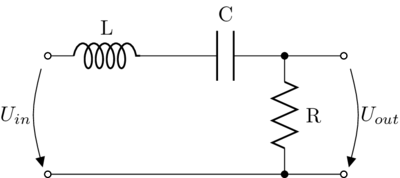

In [2]:
%%tikz -p circuitikz
\draw (0,0)              to[L=L,o-] (2,0) 
                         to[C=C] (4,0) 
                         to [R=R,*-*] (4,-2) 
                         to [short,-o] (0,-2);
\draw (0,0) to [open, v>=$U_{in}$] (0,-2);
\draw (4,0) to [short,-o] (5,0) to [open,v^>=$U_{out}$] (5,-2) to [short,o-] (4,-2);

We can readily write the transfer function in the Laplace domain, given by 

$$H(s)=\frac{U_{out}}{U_{in}}=\frac{R}{sL+\frac{1}{sC}+R}=\frac{sRC}{LCs^2+RCs+1}.$$

With the substitution $\alpha=\frac{R}{2L}$ and $\omega_0=\frac{1}{\sqrt{LC}}$ we get

$$H(s)=\frac{2\alpha s}{s^2+2\alpha s+\omega_0^2}$$

as the overall transfer function. In this equation, $\omega_0$ determines the resonant frequency of the circuit (i.e. the center frequency of the bandpass filter) and $\alpha$ determines its Q-factor (i.e. the width of the bandpass). 

Let us define some arbitrary values to yield the exemplary filter (*feel free to change the values, the graphs below adapt to these settings*):

In [2]:
f0 = 1e4     # The resonant frequency of the circuit
f1 = 5e3     # A second test frequency we are going to use below
alpha = 5000 # the damping factor
C = 1e-6     # define the capacitor value

# calculate the other parts of the circuit
L = 1/((2*np.pi*f0)**2*C)
R = 2*alpha*L

print ("R=%.2f Ohm" % R)
print ("L=%.2e Henry" % L)
print ("C=%.2e Farad" % C)

R=2.53 Ohm
L=2.53e-04 Henry
C=1.00e-06 Farad


Now, we can create a transfer function object from this, in order to numerically analyze its behaviour.

In [3]:
system = signal.TransferFunction([R*C, 0], [L*C, R*C, 1])

Let us plot the impulse response of this filter.

In [1]:
# the sampling frequency to simulate the time-continuous system in discrete time
Fs = 1e6
T = np.arange(0, 1e-3, 1/Fs)
t, h = signal.impulse2(system, T=T)

plt.figure(figsize=(8,3))
plt.plot(t*1000, h)
plt.grid(True)
plt.xlabel('$t$ [ms]')
plt.ylabel('$h(t)$');
plt.title('Impulse response of RLC circuit');

NameError: name 'np' is not defined

As we see, its an oscillating response, indicating that we indeed see a bandpass filter here. In particular, the impulse response contains 10 periods of oscillation within 1ms time, or of the frequency $10kHz$, which is exactly the resonance frequency we fixed above. Hence, we expect that a wave with frequency $10kHz$ is amplified with highest amplitude.

Let us therefore consider the frequency response of the filter, in terms of magnitude and phase:

H(f0)=0.0dB
H(f1)=-19.5dB


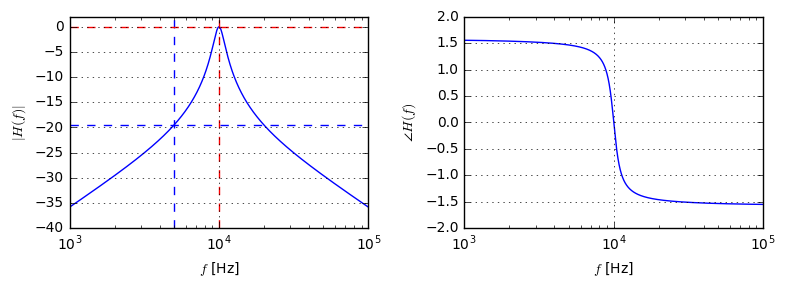

In [9]:
# calculte frequency response
w, H = signal.freqresp(system, 2*np.pi*np.logspace(0, 6, 10000))
# find indices for both test frequencies and evaluate the amplitude
indf0 = np.argmin(abs(w-2*np.pi*f0))
indf1 = np.argmin(abs(w-2*np.pi*f1))
H0 = abs(H[indf0])
H1 = abs(H[indf1])

plt.figure(figsize=(8,3))
plt.subplot(121) 
plt.semilogx(w/(2*np.pi), 20*np.log10(abs(H)))
plt.grid(True)
plt.ylim((-40, 2))
plt.xlim((1e3, 1e5))
plt.axvline(f0, color='r', ls='dashed')
plt.axvline(f1, ls='dashed')
plt.axhline(20*np.log10(H0), color='r', ls='dashed')
plt.axhline(20*np.log10(H1), ls='dashed')
plt.ylabel('$|H(f)|$'); plt.xlabel('$f$ [Hz]');

plt.subplot(122)
plt.semilogx(w/(2*np.pi), np.angle(H))
plt.grid(True)
plt.xlim((1e3, 1e5));
plt.ylabel(r'$\angle H(f)$'); plt.xlabel('$f$ [Hz]');
plt.tight_layout();

print ("H(f0)=%.1fdB" % (20*np.log10(H0)))
print ("H(f1)=%.1fdB" % (20*np.log10(H1)))

As we see, for the resonance frequency, the gain is highest, whereas for other frequencies the gain decays with the distance to the resonance frequency. In particular, for the second test frequency $f_1$, we experience a gain of $-19.5dB$, which corresponds to $|H(f_1)|\approx 0.106$. 

The group and phase delay depend on the phase spectrum of the frequency response of the filter, and are defined as follows:

$$\tau_g(\omega)=-\frac{d\angle H(\omega)}{d\omega}, \qquad \tau_\phi=-\frac{\angle H(\omega)}{\omega}.$$

Hence, for the group delay, the quicker the phase changes, the higher is the group delay. So, we expect the group delay of our filter to be especially high for frequencies around the resonance frequency, since the phase changes quickly in this region. 

In order to analyze group and phase delay, let us transform the continuous-time transfer function in Laplace-domain into the discrete-time transfer function in Z-domain. Here, we use the [Bilinear transform](https://en.wikipedia.org/wiki/Bilinear_transform "Wikipedia article"), i.e. we replace $s$ in the Lapace-domain transfer function by $$s=\frac{2}{T}\frac{z-1}{z+1},$$ where $T=1/F_s$ is the sampling interval. 

Let us employ `sympy` for the tedious calculation. First, define the Laplace-domain transfer function $H(s)$: 

H(s)=


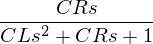

In [7]:
from sympy import symbols
from sympy import init_printing
init_printing()
R_, L_, C_, s_, z_, T_ = symbols('R L C s z T')

Hs = (s_*R_*C_)/(s_**2*L_*C_+s_*R_*C_+1)
print ("H(s)=")
Hs

Then, substitute $s$ by the Bilinear transform, to yield the discrete-time version $H(z)$:

H(z)=


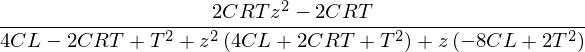

In [8]:
Hz = Hs.copy().subs(s_, 2/T_*(z_-1)/(z_+1))
print ("H(z)=")
Hz.cancel().collect(z_)

Even simpler, let `scipy` do the continuous-time to discrete-time conversion directly for us:

In [9]:
systemD = signal.cont2discrete((system.num, system.den), 1/Fs, method='bilinear')
systemD = (systemD[0][0], systemD[1], systemD[2])

Now, that we have the equivalent discrete-time system, let's evaluate the group and phase delay of our filter:

tau_g(f0)=0.20ms
tau_phi(f0)=0.000ms
tau_g(f1)=0.01ms
tau_phi(f1)=-0.047ms


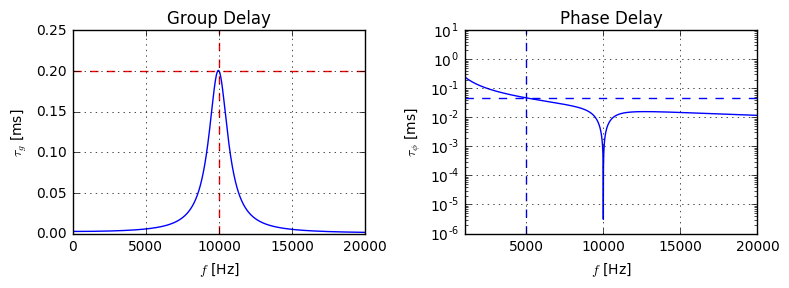

In [10]:
plt.figure(figsize=(8,3))
plt.subplot(121)
w=2*np.pi*np.linspace(100, 2e4, 50000)/Fs
_, gd = signal.group_delay(systemD[:2], w=w)  # calculate group delay
_, H = signal.dfreqresp(systemD, w=w)  # calculate frequency response

# calculate phase and group delay at the specific frequencies
indf0 = np.argmin(abs(w-2*np.pi*f0/Fs))
indf1 = np.argmin(abs(w-2*np.pi*f1/Fs))
tau_gf0 = gd[indf0]*1000/Fs
tau_gf1 = gd[indf1]*1000/Fs
tau_phif0 = (-np.angle(H[indf0])/w[indf0] /Fs*1000)
tau_phif1 = (-np.angle(H[indf1])/w[indf1] /Fs*1000)

plt.plot(w/(2*np.pi)*Fs, gd/Fs*1000)
plt.grid(True); plt.xlabel('$f$ [Hz]'); plt.ylabel(r'$\tau_g$ [ms]');
plt.title("Group Delay");
plt.axhline(tau_gf0, color='r', ls='dashed')
plt.axvline(f0, color='r', ls='dashed')

plt.subplot(122)
plt.semilogy(w/(2*np.pi)*Fs, abs(np.angle(H)/w /Fs*1000));
plt.grid(True); plt.xlim((1e3, 2e4)); plt.xlabel('$f$ [Hz]'); plt.ylabel(r'$\tau_\phi$ [ms]')
plt.title('Phase Delay');
plt.axhline(abs(tau_phif1), ls='dashed')
plt.axvline(f1, ls='dashed')
plt.tight_layout();

print ("tau_g(f0)=%.2fms" % (tau_gf0))
print ("tau_phi(f0)=%.3fms" % tau_phif0)
print ("tau_g(f1)=%.2fms" % tau_gf1)
print ("tau_phi(f1)=%.3fms" % tau_phif1)

As we have expected when looking at the phase spectrum of the filter, the group delay reaches its maximum directly at the resonance frequency. For frequencies far away from the resonance frequency, the group delay is close to zero. The phase delay becomes zero at the resonance frequency, because the phase spectrum is zero at this frequency. For the phase delay at our second test frequency $f_1$, we measure a phase delay of $-0.047ms$.

Since now the expected values for phase and group delay were obtained, let's verify these values with a numeric evaluation. First, we define an envelope function that follows a Gaussian bell. Then, we create two signal `sig1` and `sig2` and modulate the envelope function with these:

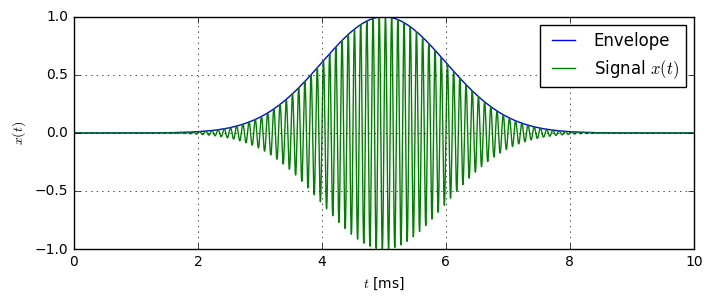

In [11]:
T = 1e-2
t = np.arange(0, T, 1/Fs)
envelope = np.exp(-5e5*(t-T/2)**2)

sig1 = envelope * np.sin(2*np.pi*f0*t)
sig2 = envelope * np.sin(2*np.pi*f1*t)
plt.figure(figsize=(8,3))
plt.plot(t*1000, envelope, label='Envelope')
plt.plot(t*1000, sig1, label='Signal $x(t)$')
plt.xlabel('$t$ [ms]')
plt.ylabel('$x(t)$')
plt.grid(True);
plt.legend();

Now, let's send both signals through the system and record its output:

In [12]:
out1 = signal.dlsim(systemD, sig1)[1]
out2 = signal.dlsim(systemD, sig2)[1]

In [13]:
# Just some helper function for nicer frequency formatting
def toKilo(f):
    if f % 1000 == 0:
        return "%dk" % (f//1000)
    else:
        return ("%.1fk" % (f/1000))

Finally, we can plot the input and the output signals against each other with the following function:

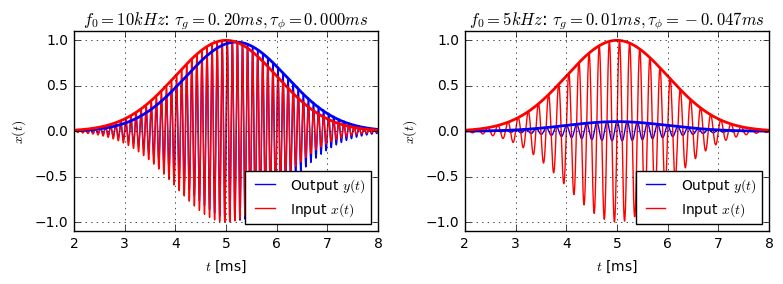

In [14]:
def plotInputOutput():
    plt.figure(figsize=(8,3))
    plt.subplot(121)
    plt.plot(t*1000, out1, 'b-', label='Output $y(t)$')
    plt.plot(t*1000, sig1, 'r-', label='Input $x(t)$')
    plt.plot(1000*t+.2, envelope*out1.max(), 'b-', lw=2)
    plt.plot(t*1000, envelope, 'r-', lw=2)
    plt.title(r'$f_0=%sHz$: $\tau_g=%.2fms,\tau_\phi=%.3fms$' % (toKilo(f0), tau_gf0, tau_phif0));
    plt.xlabel('$t$ [ms]'); plt.ylabel('$x(t)$');
    plt.xlim((1000*T/2-3, 1000*T/2+3))
    plt.ylim((-1.1, 1.1))
    plt.grid(True); plt.legend(fontsize=10, loc='lower right')

    plt.subplot(122)
    plt.plot(t*1000, out2, 'b-', label='Output $y(t)$')
    plt.plot(t*1000, sig2, 'r-', label='Input $x(t)$')
    plt.plot(t*1000, envelope*out2.max(), 'b-', lw=2)
    plt.plot(t*1000, envelope, 'r-', lw=2)
    plt.xlim((1000*T/2-3, 1000*T/2+3))
    plt.ylim((-1.1,1.1)); plt.title(r'$f_0=%sHz$: $\tau_g=%.2fms, \tau_\phi=%.3fms$' % (toKilo(f1), tau_gf1, tau_phif1));
    plt.xlabel('$t$ [ms]'); plt.ylabel('$x(t)$')
    plt.grid(True); plt.legend(fontsize=10, loc='lower right');
    plt.tight_layout()
plotInputOutput()

The left figure shows the system output for the resonance frequency. Obviously, there is a significant time-shift between the input and output envelope. We expect this shift to be equal to the group delay $\tau_g$. In the right figure, no delay is visible in the envelope. However, the sine-waves of the input and output are not synchronous, which is due to the non-zero phase delay. Let us look at a zoomed version of both charts: 

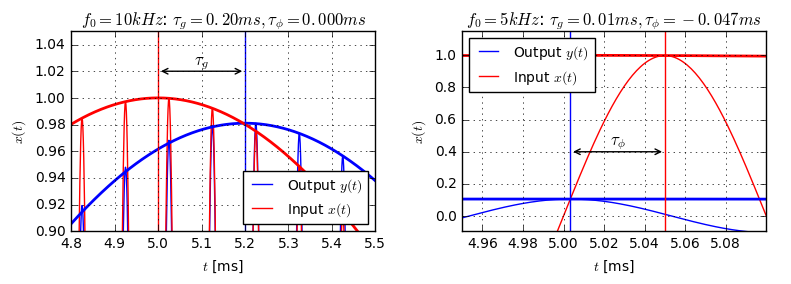

In [15]:
plotInputOutput()
plt.subplot(121);
plt.xlim((4.8, 5.5)); plt.ylim((H0-0.1, 1.05));
plt.annotate(s='',xy=(5,1.02), xytext=(5 + tau_gf0,1.02), arrowprops=dict(arrowstyle='<->'))
plt.text(5+tau_gf0/2,1.02,r'$\tau_g$',va='bottom', ha='center', fontsize=12)
plt.axvline(5,color='r'); plt.axvline(5.2);

plt.subplot(122);
plt.xlim((4.95, 5.1));
t0 = (np.round(f1*5.05/1000)+0.25) / f1 * 1000  # find time of peak of input curve around time=5.05ms
plt.axvline(t0, color='r'); plt.axvline(t0+tau_phif1)
plt.ylim((H1-0.2, 1.15));
plt.legend(loc='upper left', fontsize=10)
plt.annotate(s='',xy=(t0+tau_phif1,0.4), xytext=(t0,0.4), arrowprops=dict(arrowstyle='<->'))
plt.text(t0+tau_phif1/2,0.4,r'$\tau_\phi$',va='bottom', ha='center', fontsize=12);

Apparently, for the left figure, the output envelope is delayed exactly by the group delay $\tau_g$ and the input and output-phases are synchronous to each other, indicating that the phase delay $\tau_\phi$ is zero for the resonance frequency. On the other hand, when considering our second test frequency $f_1$, we do not see a delay in the envelopes, but instead the phases are not synchronous. The difference between the maxima of the input and output sine waves is exactly the amount of the measured phase delay $\tau_\phi$.

## Linear-Phase filters
Especially among digital filters, the term "linear-phase" filters is very common. A linear phase filter is a filter, where the phase of the filter depends linearly on the frequency. Accordingly, it has a constant group delay, i.e. the group delay is independent of the frequency. These filters have preferrable transmission properties, as they do not distort slowly the envelopes of input signal, which is often desired. Among analog filters built from RLC circuits, linear-phase filters are very rare.

## Conclusion
> The group delay $\tau_g$ and phase delay $\tau_\phi$ of a filter can be defined in terms of the behaviour of the filter on a specific type of input signal. Consider an input signal $x(t)=a(t)\sin(2\pi f t)$, where $a(t)$ is some slowly varying envelope function. Then, the output of the filter is approximately given by 
> 
> $$y(t)=h(t)*x(t)\approx a(t-\tau_g(f))\cdot\sin(2\pi f(t-\tau_\phi(f)).$$
>
> I.e. the envelope function is delayed by the group delay, whereas the carrier is delayed by the phase delay.